<a href="https://colab.research.google.com/github/jsroa15/KKBOX/blob/main/Churn_Prediction_KKBOX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modeling**

1.  Load libraires
2.  Load data
3.  Fixing unbalanced data
4.  Baseline model and evaluation
5.  Robust models and evaluation
6. Understandig results

# **1. Load libraries**

In [1]:
#Necesary importings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Machine learning models

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

#Machine learning utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# **2. Load Data**

In [2]:
#Loading Data

X_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KKBOX/X_train.csv')
X_test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KKBOX/X_test.csv')
y_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KKBOX/y_train.csv')
y_test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KKBOX/y_test.csv')



# **3. Fixing unbalanced data**

The problem with currenta data is that positives classes are really small. Almost 94% of data has negative class (Still subscribed) and only 6% is positive (has Churn).

In classification models that is a problem for model performance. We have less than 1 million on records, we are gonna use oversampling.

Resource: https://www.youtube.com/watch?v=OJedgzdipC0

In [93]:
round(y_train.value_counts()/X_train.shape[0]*100,2)

is_churn
0           93.4
1            6.6
dtype: float64

In [3]:
#Fixing

from imblearn.over_sampling import RandomOverSampler

os=RandomOverSampler(ratio=1,random_state=123)

X_train_res,y_train_res=os.fit_resample(X_train,y_train)

from collections import Counter

#Checking


print(y_train.value_counts())
print(Counter(y_train_res))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

is_churn
0           655422
1            46306
dtype: int64
Counter({0: 655422, 1: 655422})


In [4]:
#Restoring column names to X_train_res

X_train_res=pd.DataFrame(X_train_res,columns=X_train.columns)


# **4 Baseline Model and Evaluation**

Our baseline model will be a Naive Bayes Classifier

In [96]:
#Naive Bayes Classifier

model=GaussianNB()


In [97]:
def model_performance_classification(model,Xtrain,Ytrain,Xtest,Ytest):

  '''
  The function calculates metrics as Confusion matrix, AUC, Accuracy, Precision, Recall, F1 Score
  **Note**: Before running the function it's necessary to intantiate a classification model
  Parameters
  ------------------------------
  model: Classification model created prior to apply function.
  Xtrain: Your X train dataset
  Ytrain: Your Y train dataset
  Xtest: Your X test dataset
  Ytest: Your Y test dataset
  '''

  #Fit the model

  model.fit(Xtrain,Ytrain)

  #Make predictions

  y_pred=model.predict(Xtest)
  y_pred_proba=model.predict_proba(Xtest)[:,1]

  #Printing Metrics

  print('\nConfusion Matrix')
  print(confusion_matrix(Ytest, y_pred))


  print('\nScores')
  print('------------------------')
  print('AUC:',np.round(roc_auc_score(Ytest,y_pred_proba)*100,2),'%')
  print('Accuracy:',np.round(accuracy_score(Ytest,y_pred)*100,2),'%')
  print('Precision:',np.round(precision_score(Ytest,y_pred)*100,2),'%')
  print('Recall:',np.round(recall_score(Ytest,y_pred)*100,2),'%')
  print('F1 score:',np.round(f1_score(Ytest,y_pred)*100,2))

In [98]:
model_performance_classification(model,X_train_res,y_train_res,X_test,y_test)


Confusion Matrix
[[131175  32909]
 [  3859   7490]]

Scores
------------------------
AUC: 79.68 %
Accuracy: 79.04 %
Precision: 18.54 %
Recall: 66.0 %
F1 score: 28.95


Not bad for Naive Bayes Classifier. Now let's explore with robust models.

# **5.Robust Models**

In [5]:
#Robust Models

dt=DecisionTreeClassifier(random_state=123)
rf=RandomForestClassifier(random_state=123)
#sv=SVC(random_state=123)
#gb=GradientBoostingClassifier(random_state=123)
xgbc=XGBClassifier(random_state=123)
logreg=LogisticRegression(random_state=123)

models={dt:'Decision Tree',xgbc:'Xgboost',rf:'Random Forest'}


In [100]:
def performance_classification_auc(model_dictionary,Xtrain,ytrain,Xtest,ytest,folds=5):
  '''
  The function evaluates the performance of classification models via CV. The base metric is ROC AUC score
  Parameters
  ------------
    model_dictionary: A dictionary that contains as key the instantiate model and as value the model name
    Xtrain: The X train dataset
    ytrain: The y train dataset
    Xtest: The X test dataset
    ytest: The y test dataset
    folds: Number of folds to cross-validate. Default 5
  '''
  null_list1=[]
  null_list2=[]

  for key,value in model_dictionary.items():
    metric=cross_val_score(key,Xtrain,ytrain,cv=folds,scoring='roc_auc')
    
    #Store the F1 score from CV
    metric_mean=round(metric.mean()*100,2)


    #Fit and predict
    key.fit(Xtrain,ytrain)
    y_pred=key.predict_proba(Xtest)[:,1]

    #Calculate the ROC AUC Score in Test
    metric_test=round(roc_auc_score(y_test,y_pred)*100,2)
    null_list1.append(metric_mean)
    null_list2.append(metric_test)

  index=[x for x in model_dictionary.values()]
  dff=pd.DataFrame([null_list1,null_list2],index=['ROC AUC Cross Val','ROC AUC Test set']).transpose()
  dff.index=index
  print(dff)

In [101]:
performance_classification_auc(models,X_train_res,y_train_res,X_test,y_test,folds=3)

               ROC AUC Cross Val  ROC AUC Test set
Decision Tree              97.41             69.22
Xgboost                    92.65             92.77
Random Forest              99.98             94.01


From the above we can conclude that Random Forest has the best performance in Cross Validation and Test.

Now we can perform hyperparameter tuning to improve performance.

# **6.Understanding Results**

Let's see the main features that affect if customers decide to continue with subscription or churn.

In [55]:
#Extracting feature importance

feature_importance=rf.feature_importances_
feature_importance=pd.DataFrame({'Feature_Importance':feature_importance},index=X_train_res.columns)

feature_importance.sort_values(by='Feature_Importance',ascending=False,inplace=True)
feature_importance=feature_importance.reset_index()

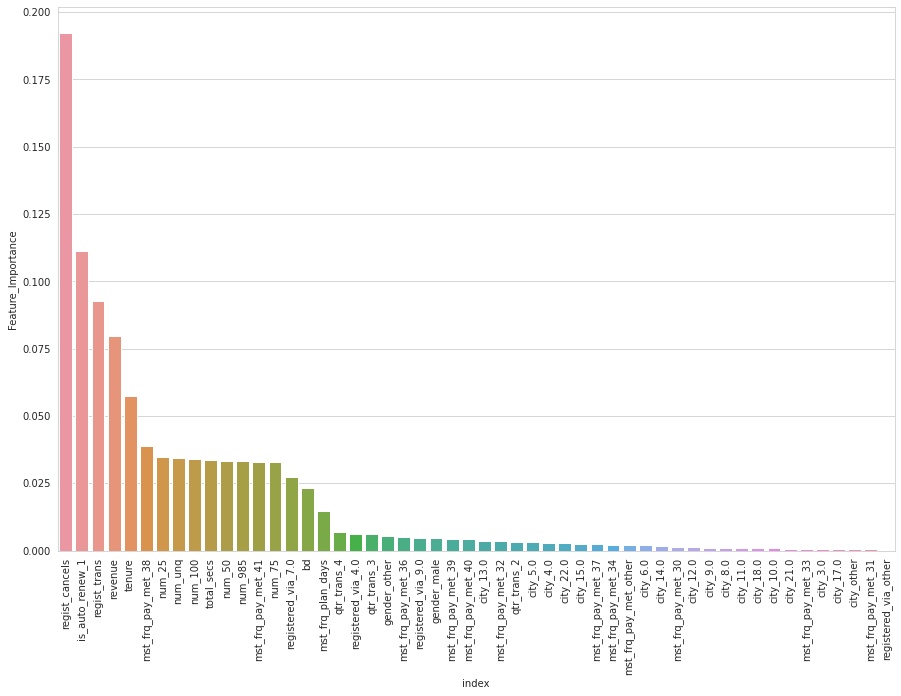

In [62]:

fig=plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
sns.barplot(data=feature_importance,x='index',y='Feature_Importance')
plt.xticks(rotation='vertical')
plt.show()

From the above, the features that have most predictive power are:       ```regist_cancels  is_auto_renew  regist_trans  revenue tenure```


